<a href="https://colab.research.google.com/github/comandir26/CNN/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import random
from typing import Any, Tuple

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [67]:
class MyDataset(Dataset):
    def __init__(self, path_to_annot_file: str, transform: Any=None, train: bool=False, test: bool=False, valid: bool=False) -> None:
        self.path_to_annot_file = path_to_annot_file
        self.data = self.get_data(path_to_annot_file, train, test, valid)
        self.transform = transform

    def get_data(self, path_to_annot_file: str, train: bool=False, test: bool=False, valid: bool=False) -> pd.DataFrame:
        data = pd.read_csv(path_to_annot_file, usecols = (0, 2), names = ('path_to_image', 'label'))
        data = data.sample(frac=1).reset_index(drop=True)
        data['label'] = data['label'].apply(lambda label: 0 if label == 'rose' else 1)
        train_size = int(0.8 * data.shape[0])
        test_valid_size = int(0.1 * data.shape[0])
        if train == True:
            data = data.iloc[:train_size, :]
        elif test == True:
            data = data.iloc[train_size:train_size + test_valid_size, :]
        elif valid == True:
            data = data.iloc[train_size + test_valid_size:, :]
        return data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        path_to_image = self.data.iloc[index, 0]
        image = cv2.cvtColor(cv2.imread(path_to_image) , cv2.COLOR_BGR2RGB)
        label = self.data.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        return image, label


In [68]:
df = pd.read_csv('paths.csv', usecols = (0, 2), names = ('path_to_image', 'label'))

In [69]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                    torchvision.transforms.RandomHorizontalFlip(p=0.5)])

In [70]:
train_data = MyDataset(path_to_annot_file='paths.csv', transform=transforms, train = True)
test_data = MyDataset(path_to_annot_file='paths.csv', transform=transforms, test = True)
valid_data = MyDataset(path_to_annot_file='paths.csv', transform=transforms, valid = True)

In [71]:
len(train_data), len(test_data), len(valid_data)

(1600, 200, 200)

In [72]:
train_data.data['label'].value_counts()

label
0    814
1    786
Name: count, dtype: int64

In [73]:
test_data.data['label'].value_counts()

label
1    106
0     94
Name: count, dtype: int64

In [74]:
valid_data.data['label'].value_counts()

label
1    106
0     94
Name: count, dtype: int64

In [75]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,
                                stride = 2)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                                stride = 2)
        self.fully_connect1 = nn.Linear(5408, 10)
        self.fully_connect2 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.max_pool = nn.MaxPool2d(2)

    def forward(self, x:torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = torch.nn.Flatten()(output)
        output = self.relu(self.fully_connect1(output))
        output = torch.nn.Sigmoid()(self.fully_connect2(output))
        return output

In [76]:
parameters = {'lr': [0.001, 0.01, 0.1],
             'batch_size' : [16, 32, 48]}


c:\Users\PCmen\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1, train_accuracy: 0.7562500000000003, train_loss: 0.5020049214363098
Epoch: 1, valid_accuracy: 0.8650000000000001, valid_loss: 0.36690717935562134
Epoch: 2, train_accuracy: 0.8250000000000005, train_loss: 0.3991795778274536
Epoch: 2, valid_accuracy: 0.8350000000000001, valid_loss: 0.39193326234817505
Epoch: 3, train_accuracy: 0.8337500000000007, train_loss: 0.37531742453575134
Epoch: 3, valid_accuracy: 0.8849999999999999, valid_loss: 0.2960347831249237
Epoch: 4, train_accuracy: 0.8506250000000009, train_loss: 0.33914509415626526
Epoch: 4, valid_accuracy: 0.9249999999999999, valid_loss: 0.24550846219062805
Epoch: 5, train_accuracy: 0.8775000000000012, train_loss: 0.30719107389450073
Epoch: 5, valid_accuracy: 0.9299999999999998, valid_loss: 0.20136357843875885
Epoch: 6, train_accuracy: 0.8862500000000012, train_loss: 0.26261046528816223
Epoch: 6, valid_accuracy: 0.9149999999999999, valid_loss: 0.2030661404132843
Epoch: 7, train_accuracy: 0.895000000000001, train_loss: 0.253328293

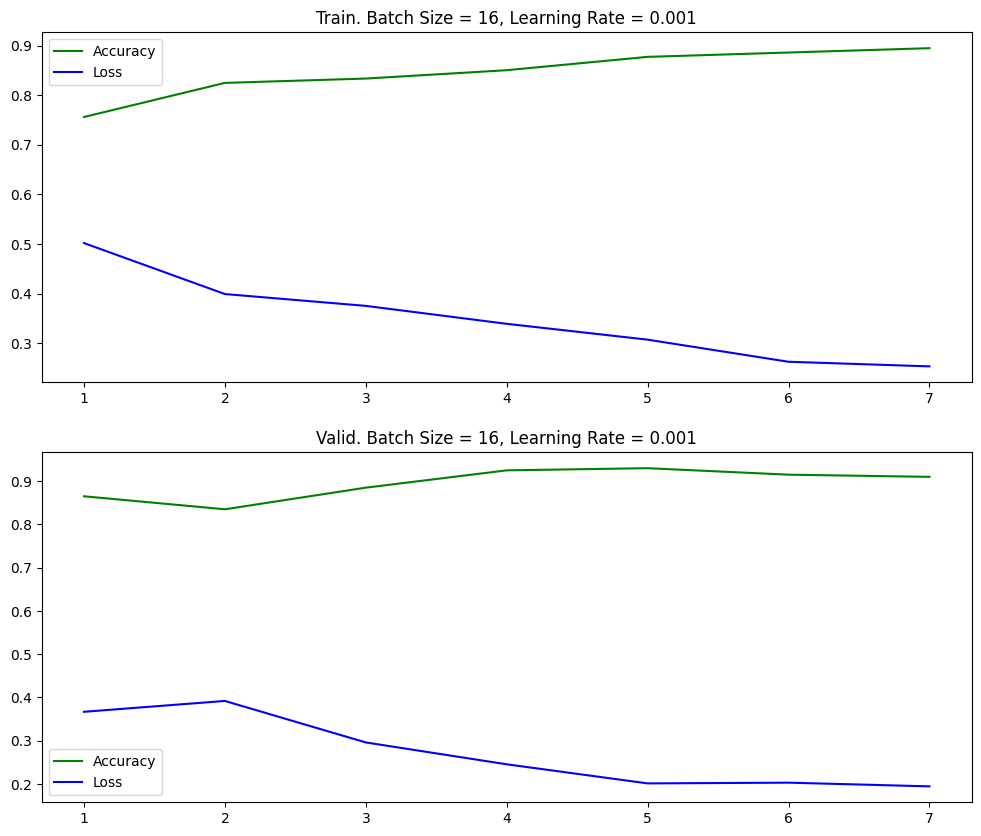

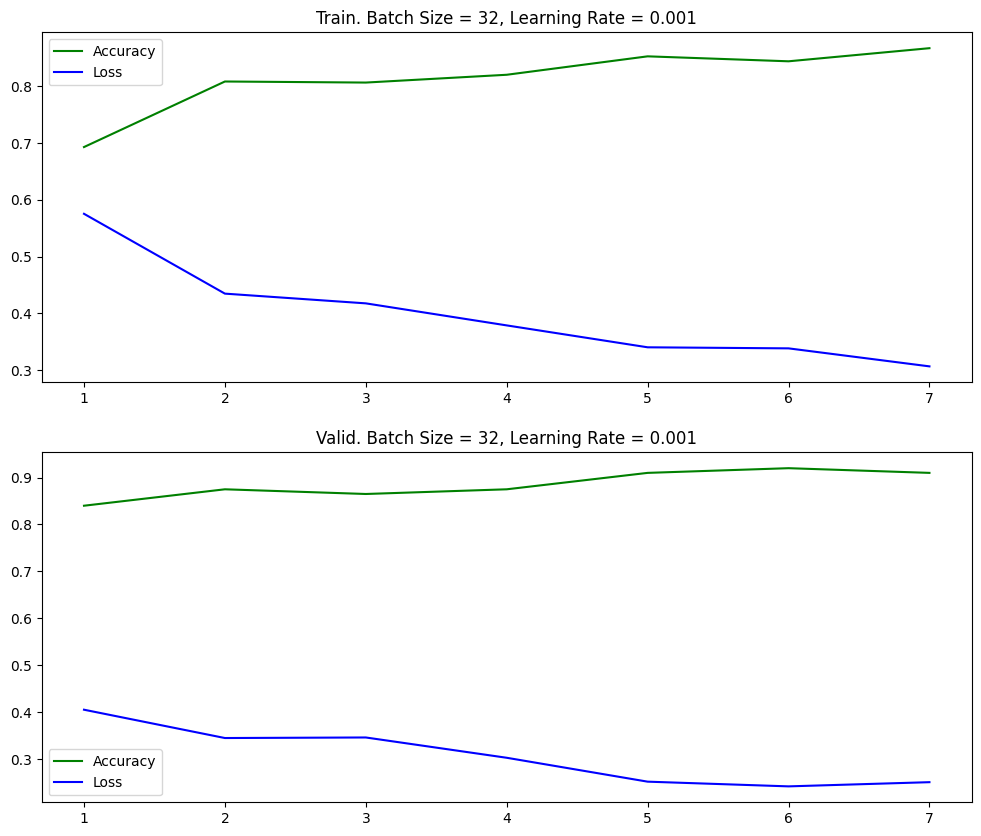

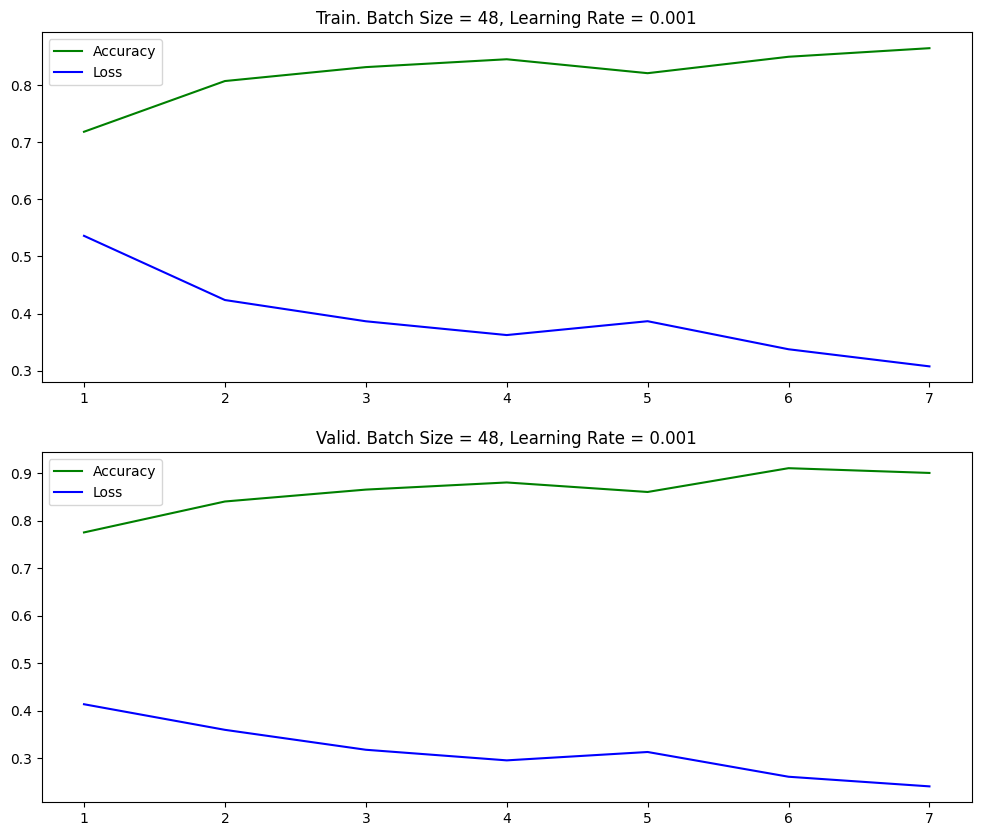

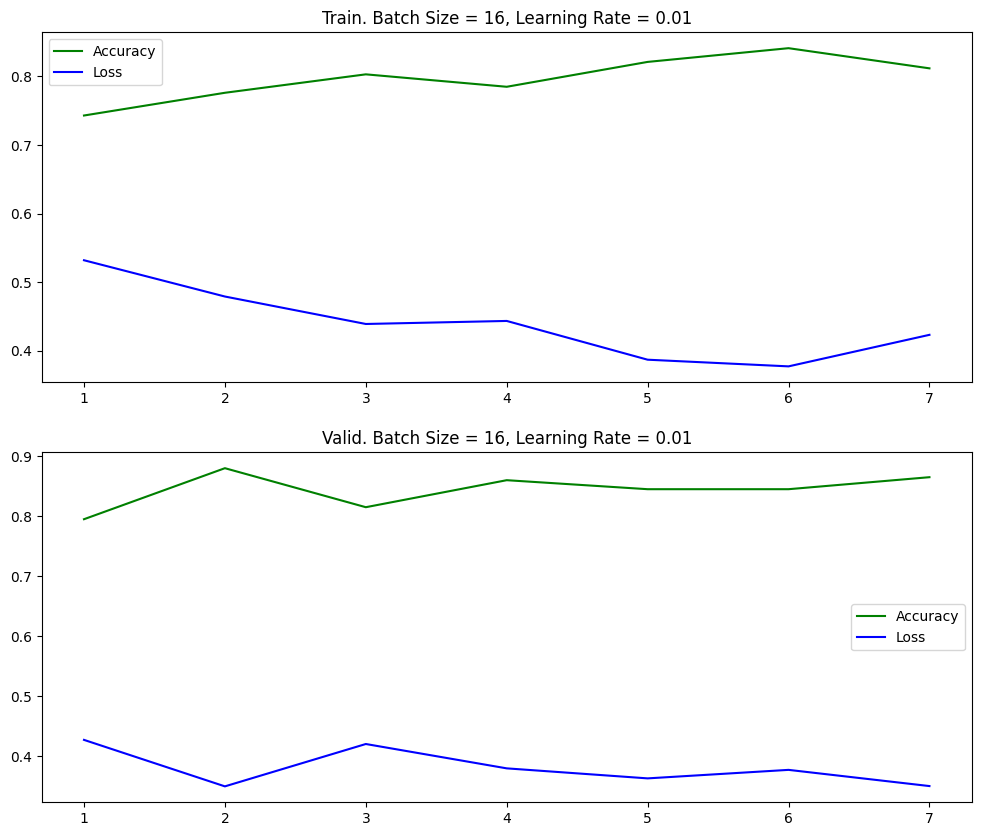

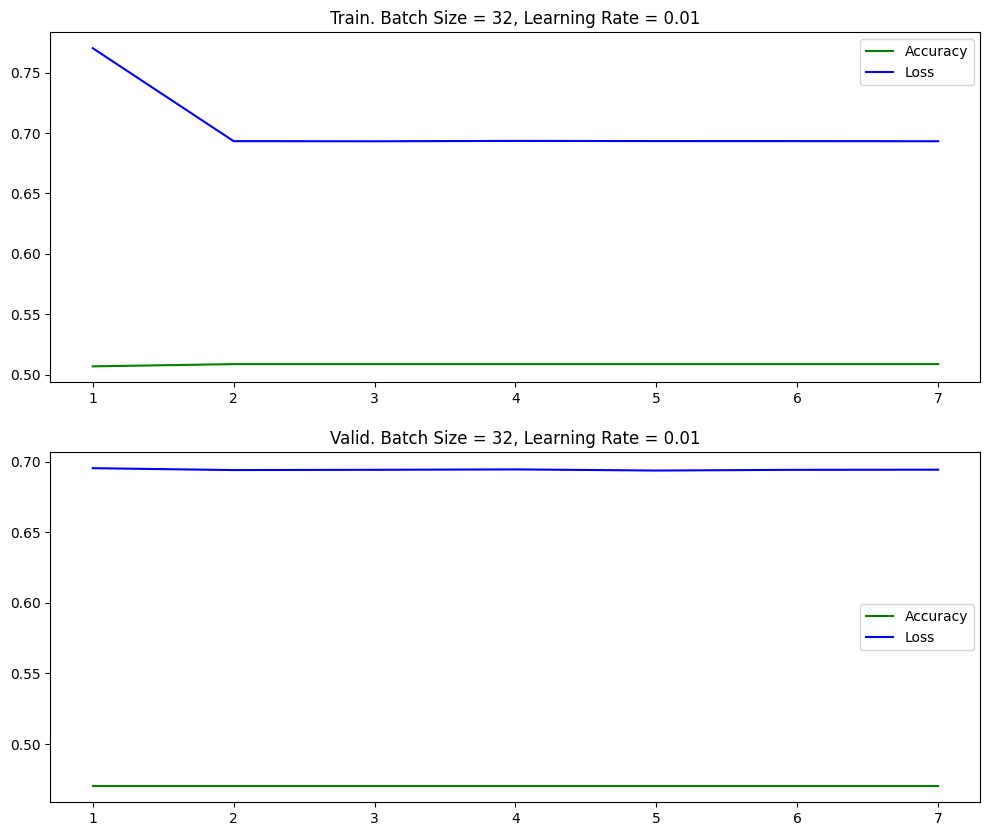

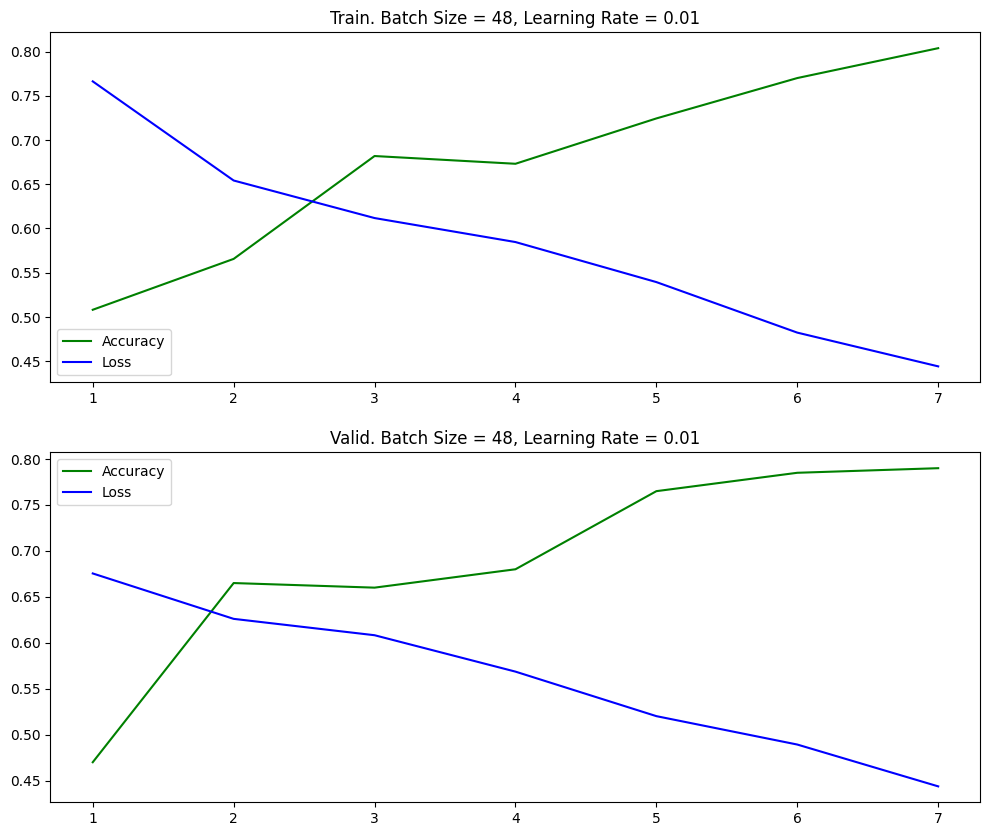

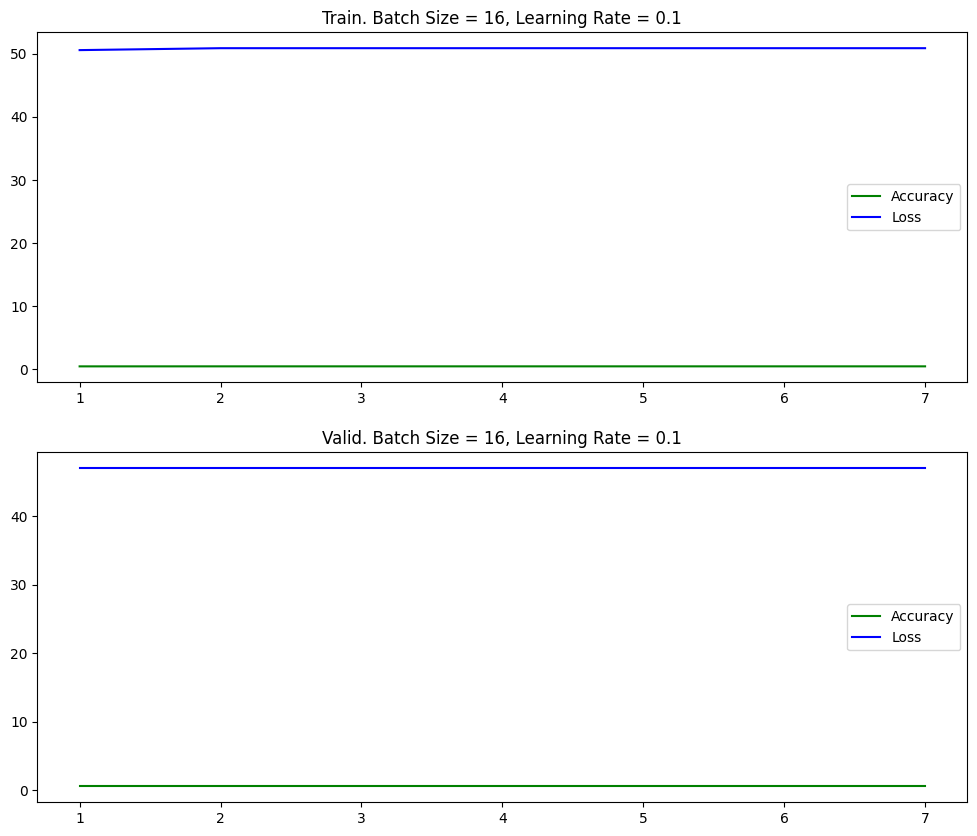

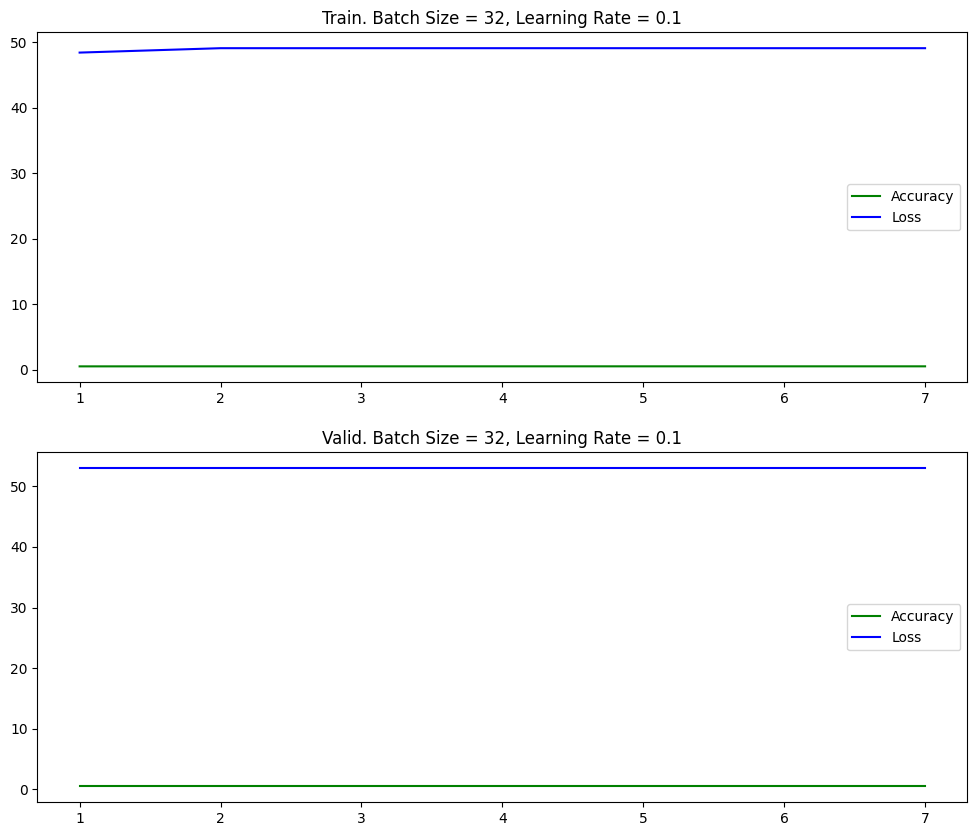

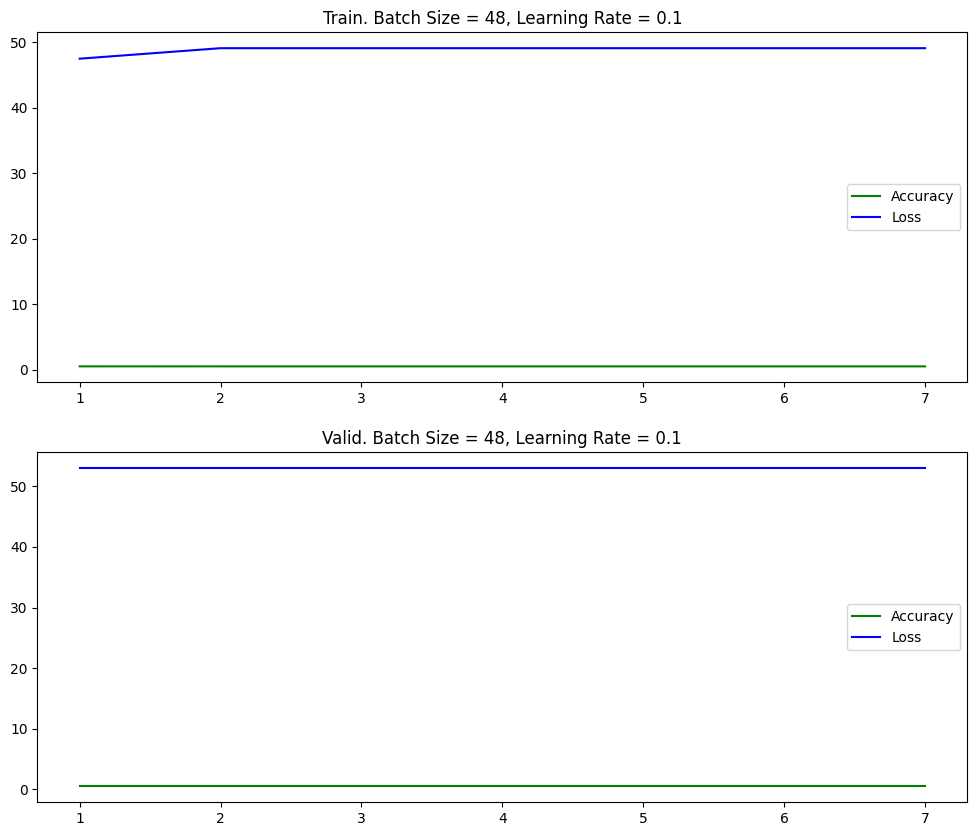

In [77]:
for lr in parameters['lr']:
    for bs in parameters['batch_size']:
        device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
        model = CNN().to(device)

        optimizer = optim.Adam(params=model.parameters(), lr=lr)
        criterion = nn.BCELoss(reduction='sum')

        train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle = True)
        test_loader = DataLoader(dataset=test_data, batch_size=bs, shuffle = False)
        valid_loader = DataLoader(dataset=valid_data, batch_size=bs, shuffle = False)

        epochs = 7

        train_accuracy_values = []
        train_loss_values = []

        val_accuracy_values = []
        val_loss_values = []

        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            epoch_accuracy = 0

            epoch_val_loss = 0
            epoch_val_accuracy = 0

            for data, label in train_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

                epoch_accuracy += acc / len(train_data)
                epoch_loss += loss / len(train_data)

            model.eval()
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

                epoch_val_accuracy += acc / len(valid_data)
                epoch_val_loss += loss / len(valid_data)

            val_accuracy_values.append(epoch_val_accuracy)
            val_loss_values.append(epoch_val_loss)

            train_accuracy_values.append(epoch_accuracy)
            train_loss_values.append(epoch_loss)

            print('Epoch: {}, train_accuracy: {}, train_loss: {}'.format(epoch + 1, epoch_accuracy, epoch_loss))
            print('Epoch: {}, valid_accuracy: {}, valid_loss: {}'.format(epoch + 1, epoch_val_accuracy, epoch_val_loss))

        train_loss_values = [value.cpu().detach().numpy() for value in train_loss_values]
        val_loss_values = [value.cpu().detach().numpy() for value in val_loss_values]

        plt.figure(figsize=(12,10))

        plt.subplot(2, 1, 1)
        plt.title(f"Train. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), train_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), train_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])

        plt.subplot(2, 1, 2)
        plt.title(f"Valid. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), val_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), val_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])

        model.eval()
        test_loss = 0
        test_accuracy = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

            acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

            test_accuracy+=acc / len(test_data)
            test_loss+=loss / len(test_data)

        torch.save(model.state_dict(), f"bs{bs}_lr{lr}_weight.pt")

        print('LR: {}, BS: {}, test_accuracy: {}, test_loss: {}'.format(lr, bs, test_accuracy, test_loss))

In [78]:
best_model = CNN()
best_model.load_state_dict(torch.load("bs32_lr0.001_weight.pt"))
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
best_model.to(device)

CNN(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (fully_connect1): Linear(in_features=5408, out_features=10, bias=True)
  (fully_connect2): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


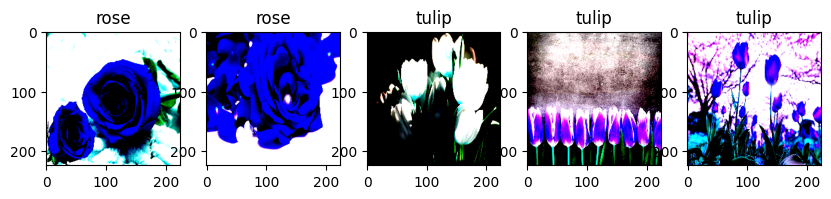

In [82]:
plt.figure(figsize=(10, 5))

for j in range(5):
  index = random.randint(0, len(test_data) - 1)
  plt.subplot(1, 5, j + 1)
  plt.title("rose" if (1 if  best_model(test_data[index][0].unsqueeze(dim=0).to(device))[0] >= 0.5 else 0) == 0 else "tulip")
  plt.imshow(test_data[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])